# Convex Optimization Project
## Support Vector Machines solvers

Given $m$ data points $x_i \in \mathbb{R}^n$ with labels $y_i \in \{-1,1\}$, write a function to solve the classification problem

$$ \begin{array}l
\mathrm{minimize} & \frac12 {||w||}_2^2 + C \mathbf{1}^Tz \\
\mathrm{subject\ to} & y_i(w^Tx_i) \geq 1 - z_i, \quad \forall i \in \{1,\ldots,m\} \\
& z \succcurlyeq 0
\end{array} $$

in the variables $w \in \mathbb{R}^n$, $z \in \mathbb{R}^m$, and its dual (warning: this problem is a bit different from the one in exercise 1).

Solving this problem trains a classifier vector $w$ such that, up to some errors

$$ \begin{array}l
w^Tx_i > 0 & \mathrm{when}\ y_i = 1 \\
w^Tx_i < 0 & \mathrm{when}\ y_i = -1.
\end{array} $$

This classifier can then be used to classify new points $x$ as positives or negatives by simply computing the scalar product $w^Tx$.

In [1]:
%pylab inline
from scipy.spatial.distance import cdist
import sklearn.svm
import cvxopt

Populating the interactive namespace from numpy and matplotlib


### General optimization functions

In [2]:
def newton(f, gradient_and_hessian, ɛ, x0, α=0.45, β=0.8):
    """
    Newton descent method.
    @param f is the function to minimize
    @param gradient_and_hessian is a function that returns the gradient and the hessian at x
    @param ɛ is the required absolute precision
    @param x0 is a strictly feasible point, i.e., f(x0) < +inf
    @param α is a parameter for the backtracking line search
    @param β is a parameter for the backtracking line search
    @return a dictionary
    """    
    x = x0
    assert(f(x0) < float("inf"))
    central_path = [copy(x)]
    while True:
        # Direction computation.
        gradient, hessian = gradient_and_hessian(x)
        hessian_inv = inv(hessian)
        dx = -hessian_inv.dot(gradient)
        
        # Stopping criterion.
        λsquare = gradient.dot(-dx)
        if λsquare/2 <= ɛ:
            break
        
        # Backtracking line search.
        t = 1.0
        f0 = f(x)
        Δ = -λsquare
        # TODO: make the thing better looking for fguth.
        prev_fx = float("inf")
        while f(x + t*dx) > f0 + α*t*Δ and (f(x + t*dx) < prev_fx or prev_fx == float("inf")):
            t *= β
            prev_fx = f(x + t*dx)
        
        # Update.
        x += t*dx
        central_path.append(copy(x))
        
    results = {
        "primal_solution":  copy(x),
        "primal_objective": f(x),
        "central_path":     vstack(central_path),
    }
    return results

def barrier_method(objective, objective_gh, m, constraints, constraints_gh, ɛ, x0, t0=1.0, μ=10.0, **newton_params):
    """
    Barrier method for inequality-constrained optimization problem.
    @param objective is the function to minimize
    @param objective_gh is a function which returns the gradient and the hessian of the objective
    @param m is the number of (inequality) constraints
    @param constraints is a function which returns the array (of shape m) of the f_i(x) where f_i(x) <= 0
    @param constraints_gh is a function which returns the array of gradients and hessians of sum(-log(-fi(x)))
    @param ɛ is the required absolute precision
    @param x0 is a strictly feasible point, i.e., objective(x0) < +inf and constraints(x0) < 0
    @param t0 is a barrier parameter
    @param μ is a barrier parameter
    @param **newton_params are the additional newton method parameters
    @return a dictionary
    """
    x = x0
    t = t0
    central_path = [copy(x)]
    
    # We minimize objective + 1/t sum (-log(-constraints))
    def f(x):
        cons = constraints(x)
        if any(cons >= 0):
            return float("inf")
        return objective(x) - sum(log(-cons))/t
    def gradient_and_hessian(x):
        obj_g, obj_h = objective_gh(x)
        cons_g, cons_h = constraints_gh(x)
        return obj_g + cons_g/t, obj_h + cons_h/t
    
    while True:
        x = newton(f, gradient_and_hessian, ɛ, x, **newton_params)["primal_solution"]
        # Stopping criterion.
        if m/t <= ɛ:
            break
        t *= μ
        central_path.append(copy(x))
    
    cx = constraints(x)
    results = dict()
    results["primal_solution"] = copy(x)
    results["primal_objective"] = f(x)
    results["dual_solution"] = -1/(t*cx)
    results["dual_objective"] = results["primal_objective"] + results["dual_solution"].dot(cx)
    results["central_path"] = vstack(central_path)
    return results

### Kernels

In [3]:
def linear_kernel(X1, X2):
    return X1.dot(X2.T)

def affine_kernel(X1, X2):
    return linear_kernel(X1, X2) + 1

def exponential_kernel(σ):
    def exponential_kernel_σ(X1, X2):
        return np.exp(-cdist(X1, X2) / (2*σ))
    return exponential_kernel_σ

def polynomial_kernel(d):
    def polynomial_kernel_d(X1, X2):
        return (affine_kernel(X1, X2)) ** d
    return polynomial_kernel_d

kernels = {
    "linear": linear_kernel,
    "affine": affine_kernel,
    "exponential": exponential_kernel(1),
    "polynomial": polynomial_kernel(4),
}
n_kernels = len(kernels)

### Classifiers

If we compute the dual, we get the following minimization problem:
\begin{equation*}
\begin{aligned}
& \underset{\alpha}{\text{minimize}}
& & \frac12 \alpha^T \mathbf{diag}(y)XX^T\textbf{diag}(y)\alpha - \mathbf{1}^T\alpha \\
& \text{subject to}
& & 0 \le \alpha \le C
\end{aligned}
\end{equation*}

where we can recover the primal solution: $w= \sum_{i=1}^m \alpha_i y_i x_i$

Thus, we use the barrier method to solve both primal and duals:
\begin{equation*}
\begin{aligned}
& \underset{\alpha}{\text{minimize}}
& & \frac12 \alpha^T \mathbf{diag}(y)XX^T\textbf{diag}(y)\alpha - \mathbf{1}^T\alpha - \frac1t \sum_{i=1}^m (\log(\alpha_i) + \log(C - \alpha_i))
\end{aligned}
\end{equation*}

We first compute the formula for the gradient and the hessian matrix.
We first set $H = \mathbf{diag}(y)XX^T\textbf{diag}(y)$.
Then, we get:
$$\nabla f = H \alpha - \mathbf{1} + \frac1t \sum_{i=1}^m (-\frac1{\alpha_i} + \frac1{C-\alpha_i})e_i\\
\nabla^2 f = H + \frac1t \textbf{diag}(\frac1{\alpha_i^2} + \frac1{(C-\alpha_i)^2})
$$

In [4]:
def svm_barrier(x, y, c, kernel, ɛ, **barrier_params):
    """
    Solve the SVM classifier problem.
    @param x is an array of shape (m,n): the m points in dimension n
    @param y is an array of shape m and of values in {-1,1}: the labels
    @param c is the margin parameter
    @param kernel is the kernel function, which takes 2D arrays as inputs
    @param ɛ is the required absolute precision
    @param barrier_params are the additional barrier method parameters
    @return a dictionnary, with at least the α field
    """
    m, n = x.shape
    # α = c/2 is a stricly feasible point.
    α0 = c/2 * ones(m)
    h = kernel(x, x) * y[:, None] * y[None, :]
    
    def objective(α):
        return h.dot(α).dot(α)/2 - sum(α)
    def objective_gh(α):
        return h.dot(α) - 1, h
    def constraints(α):
        return concatenate((-α, α-c))
    def constraints_gh(α):
        gradient = -1/α + 1/(c-α)
        hessian = diag(1/α**2 + 1/(c-α)**2)
        return gradient, hessian
    
    results = barrier_method(objective, objective_gh, 2*m, constraints, constraints_gh, ɛ, α0, **barrier_params)
    results["α"] = results["primal_solution"]
    
    return results

def svm_sklearn(x, y, c, kernel, ɛ, **svc_params):
    m, n = x.shape
    classifier = sklearn.svm.SVC(C=c, kernel=kernel, tol=ɛ, **svc_params)
    classifier.fit(x, y)
    
    α = zeros(m)
    n_support = len(classifier.support_)
    for i in range(n_support):
        α[classifier.support_[i]] = abs(classifier.dual_coef_[0][i])
    results = {
        "α": α
    }
    print(results["α"].shape, x.shape[0])
    return results    

def svm_cvxopt(x, y, c, kernel, ɛ, **cvxopt_params):
    cvxopt.solvers.options['show_progress'] = False
    cvxopt.solvers.options['abstol'] = ɛ
    
    # minimize 1/2 x^T P x + q^T x subject to Gx <= h
    m, n = x.shape
    P = cvxopt.matrix(kernel(x, x) * y[:, None] * y[None, :])
    q = cvxopt.matrix(-ones(m))
    G = cvxopt.matrix(concatenate((-eye(m), eye(m)), axis=0))
    h = cvxopt.matrix(concatenate((zeros(m), c*ones(m))))
    
    results = cvxopt.solvers.qp(P, q, G, h)
    results["α"] = array(results["x"]).flatten()
    return results
    
classifiers = {
    "barrier": svm_barrier,
    "sklearn": svm_sklearn,
    "cvxopt":  svm_cvxopt,
}
n_classifiers = len(classifiers)

def train(classifier_name, x, y, c, kernel, ɛ, **classifier_params):
    """
    Trains a classifier, and adds the support vectors and the predict functions to the result dictionnary.
    """
    results = classifiers[classifier_name](x, y, c, kernel, ɛ, **classifier_params)
    α = results["α"]
    support_vectors_indices = where(α > 1e-6)[0]
    support_vectors = x[support_vectors_indices]
    support_vectors_weights = α[support_vectors_indices] * y[support_vectors_indices]
    
    def predict(x):
        return kernel(x, support_vectors).dot(support_vectors_weights)
    def predict_labels(x):
        return (predict(x) > 0.) * 2 - 1
    
    results["support_vectors_indices"] = support_vectors_indices
    results["support_vectors_weights"] = support_vectors_weights
    results["support_vectors"] = support_vectors
    results["predict"] = predict
    results["predict_labels"] = predict_labels
    return results

### Data generation

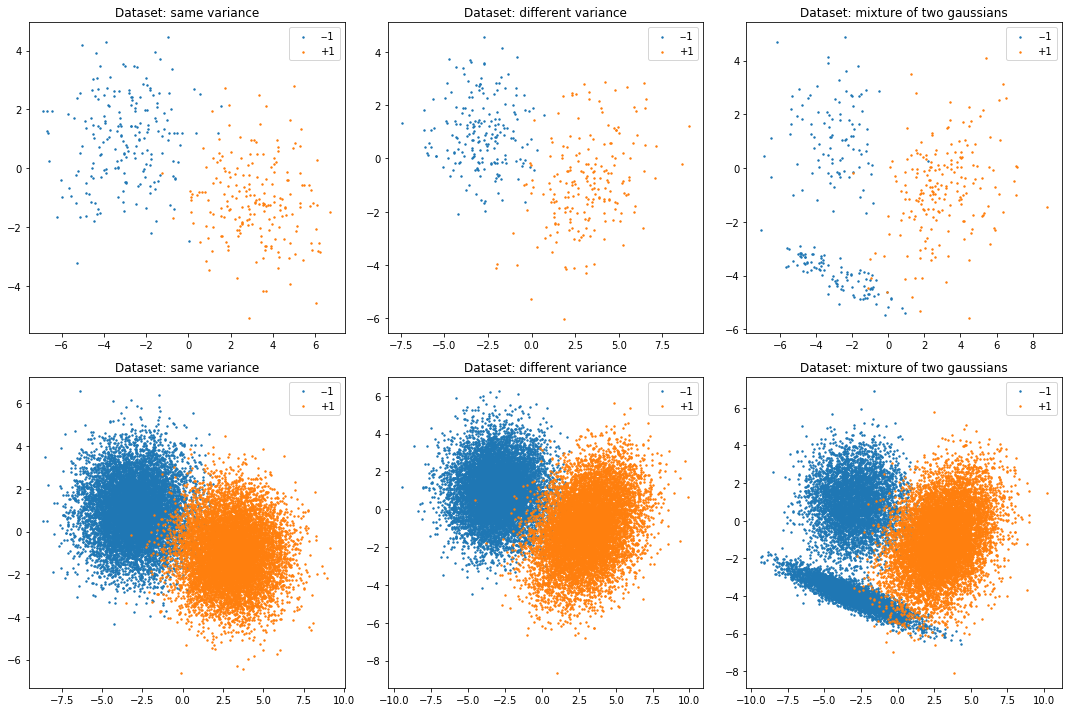

In [5]:
def data_points(μ1, Σ1, μ2, Σ2, n_train, n_test, μ3=None, Σ3=None):
    """
    Generates a dataset composed of two bivariate gaussian samples with different means.
    @param μ1 is the mean of the first sample (+1)
    @param Σ1 is the covariance matrix of the first sample (+1)
    @param μ2 is the mean of the second sample (-1)
    @param Σ2 is the covariance matrix of the second sample
    @param n_train is the number of points of each sample in the training set
    @param n_train is the number of points of each sample in the training set
    @param μ3 is the mean of the first sample (+1) (if provided, will make a mixture of gaussians)
    @param Σ3 is the covariance matrix of the first sample (+1) (if provided, will make a mixture of gaussians)
    @return ((x_train, y_train), (x_test, y_test))
    """
    def pos_examples(n):
        pos_examples = random.multivariate_normal(μ1, Σ1, n)
        if μ3 is not None:
            pos_examples[:n//2] = random.multivariate_normal(μ3, Σ3, n//2)
        return pos_examples
    def neg_examples(n):
        return random.multivariate_normal(μ2, Σ2, n)
    def generate(n):
        x = concatenate((pos_examples(n), neg_examples(n)), axis=0)
        y = concatenate((ones(n),         -ones(n)),        axis=0)
        return x,y
    return generate(n_train), generate(n_test)

def plot_dataset(dataset, test=False):
    """
    Plots training or testing points in the dataset.
    """
    x, y = dataset[int(test)]
    scatter(x[y ==  1][:, 0], x[y ==  1][:, 1], s=2, label="--1")
    scatter(x[y == -1][:, 0], x[y == -1][:, 1], s=2, label="+1")
    title("Dataset: {}".format(name))
    legend()

μ1 = array([-3, 1])
Σ1 = array([[2.5,0],[0,2]])
μ2 = array([3, -1])
Σ2 = array([[3, 1],[1, 3]])
μ3 = array([-3,-4])
Σ3 = array([[4,-1.25],[-1.25,0.5]])
n_train = 200
n_test = 10000
datasets = {
    "same variance":            data_points(μ1, Σ1, μ2, Σ1, n_train, n_test),
    "different variance":       data_points(μ1, Σ1, μ2, Σ2, n_train, n_test),
    "mixture of two gaussians": data_points(μ1, Σ1, μ2, Σ2, n_train, n_test, μ3, Σ3),
}
n_datasets = len(datasets)

figure(figsize=(5*n_datasets,10))
i = 0
for name in datasets:
    i += 1
    subplot(2, n_datasets, i)
    title(name+" (train)")
    plot_dataset(datasets[name], test=False)
    subplot(2, n_datasets, i+n_datasets)
    name+" (test)"
    plot_dataset(datasets[name], test=True)
tight_layout()

### Test functions

In [6]:
def plot_contours(results, xx, yy, **contourf_params):
    """
    Plot the decision boundaries of a classifier.
    @param results is the result dictionnary of a classifier
    @param xx is the meshgrid array
    @param yy is the meshgrid array
    @param contourf_params are the additional contourf parameters
    """
    z = results["predict"](c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    contourf(xx, yy, z, [-1, 0, 1], **contourf_params)
    contour( xx, yy, z, [-1, 0, 1], colors=["C1", "C7", "C0"])

def plot_results(axes, dataset_name, classifier_name, kernel_name, c=1, ɛ=1e-10):
    dataset = datasets[dataset_name]
    (x_train, y_train), (x_test, y_test) = dataset
    results = train(classifier_name, x_train, y_train, c, kernels[kernel_name], ɛ)
    
    plot_dataset(dataset)
    
    n_grid = 100
    x_min, x_max = axes.get_xlim()
    y_min, y_max = axes.get_ylim()
    xx, yy = meshgrid(linspace(x_min, x_max, n_grid), linspace(y_min, y_max, n_grid))
    plot_contours(results, xx, yy, cmap=plt.cm.coolwarm_r)
    
    scatter(results["support_vectors"][:, 0], results["support_vectors"][:, 1], s=10, linewidth=1, c='gray')
    title("Dataset: {}, classifier: {}\n{} kernel, C={:.0e}".format(
        dataset_name, classifier_name, kernel_name, c), fontsize="x-large")
    
    def accuracy(x, y):
        labels = results["predict_labels"](x)
        return mean(labels != y) * 100
    xlabel("Train Error: {:.2f}%      Test Error: {:.2f}%".format(
        accuracy(x_train, y_train), accuracy(x_test, y_test)), fontsize="large")

### Choice of kernel

Dataset: same variance, linear kernel
CPU times: user 2.02 s, sys: 44 ms, total: 2.06 s
Wall time: 569 ms
Dataset: different variance, linear kernel
CPU times: user 1.88 s, sys: 28 ms, total: 1.91 s
Wall time: 502 ms
Dataset: mixture of two gaussians, linear kernel
CPU times: user 1.82 s, sys: 12 ms, total: 1.83 s
Wall time: 473 ms
Dataset: same variance, affine kernel
CPU times: user 1.74 s, sys: 24 ms, total: 1.76 s
Wall time: 464 ms
Dataset: different variance, affine kernel
CPU times: user 1.77 s, sys: 20 ms, total: 1.79 s
Wall time: 462 ms
Dataset: mixture of two gaussians, affine kernel
CPU times: user 2.19 s, sys: 96 ms, total: 2.29 s
Wall time: 650 ms
Dataset: same variance, exponential kernel
CPU times: user 2.23 s, sys: 20 ms, total: 2.25 s
Wall time: 574 ms
Dataset: different variance, exponential kernel
CPU times: user 4.82 s, sys: 588 ms, total: 5.41 s
Wall time: 1.96 s
Dataset: mixture of two gaussians, exponential kernel
CPU times: user 2.59 s, sys: 48 ms, total: 2.64 s


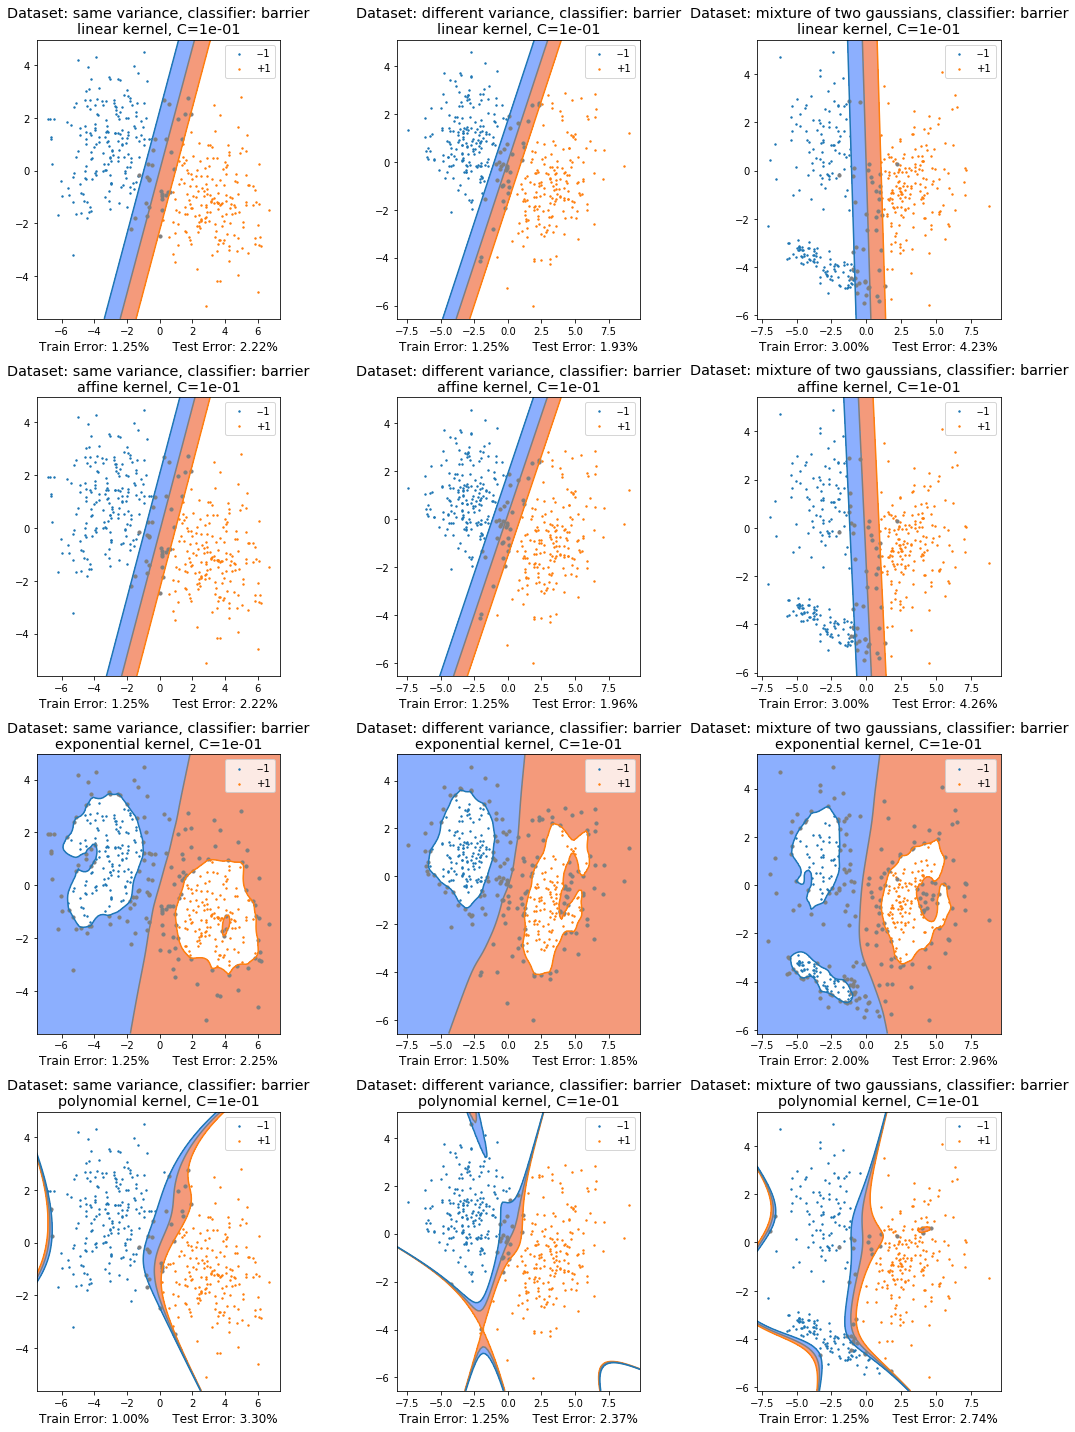

In [7]:
figure(figsize=(5*n_datasets,5*n_kernels))
i = 0
for kernel in kernels:
    for dataset in datasets:
        i += 1
        axes = subplot(n_kernels, n_datasets, i)
        print("Dataset: {}, {} kernel".format(dataset, kernel))
        %time plot_results(axes, dataset, "barrier", kernel, c=1e-1)
tight_layout()

# TODO commentary

### Influence of $C$

Dataset: same variance, C=0.001
CPU times: user 3.62 s, sys: 236 ms, total: 3.85 s
Wall time: 1.17 s
Dataset: different variance, C=0.001
CPU times: user 3.36 s, sys: 68 ms, total: 3.42 s
Wall time: 954 ms
Dataset: mixture of two gaussians, C=0.001
CPU times: user 3.61 s, sys: 160 ms, total: 3.77 s
Wall time: 1.07 s
Dataset: same variance, C=0.01
CPU times: user 2.99 s, sys: 68 ms, total: 3.06 s
Wall time: 828 ms
Dataset: different variance, C=0.01
CPU times: user 3.14 s, sys: 140 ms, total: 3.28 s
Wall time: 950 ms
Dataset: mixture of two gaussians, C=0.01
CPU times: user 3.76 s, sys: 176 ms, total: 3.94 s
Wall time: 1.27 s
Dataset: same variance, C=0.1
CPU times: user 7.46 s, sys: 468 ms, total: 7.92 s
Wall time: 2.95 s
Dataset: different variance, C=0.1
CPU times: user 3.44 s, sys: 192 ms, total: 3.63 s
Wall time: 1 s
Dataset: mixture of two gaussians, C=0.1
CPU times: user 2.46 s, sys: 32 ms, total: 2.49 s
Wall time: 642 ms
Dataset: same variance, C=1.0
CPU times: user 2.49 s, sys:

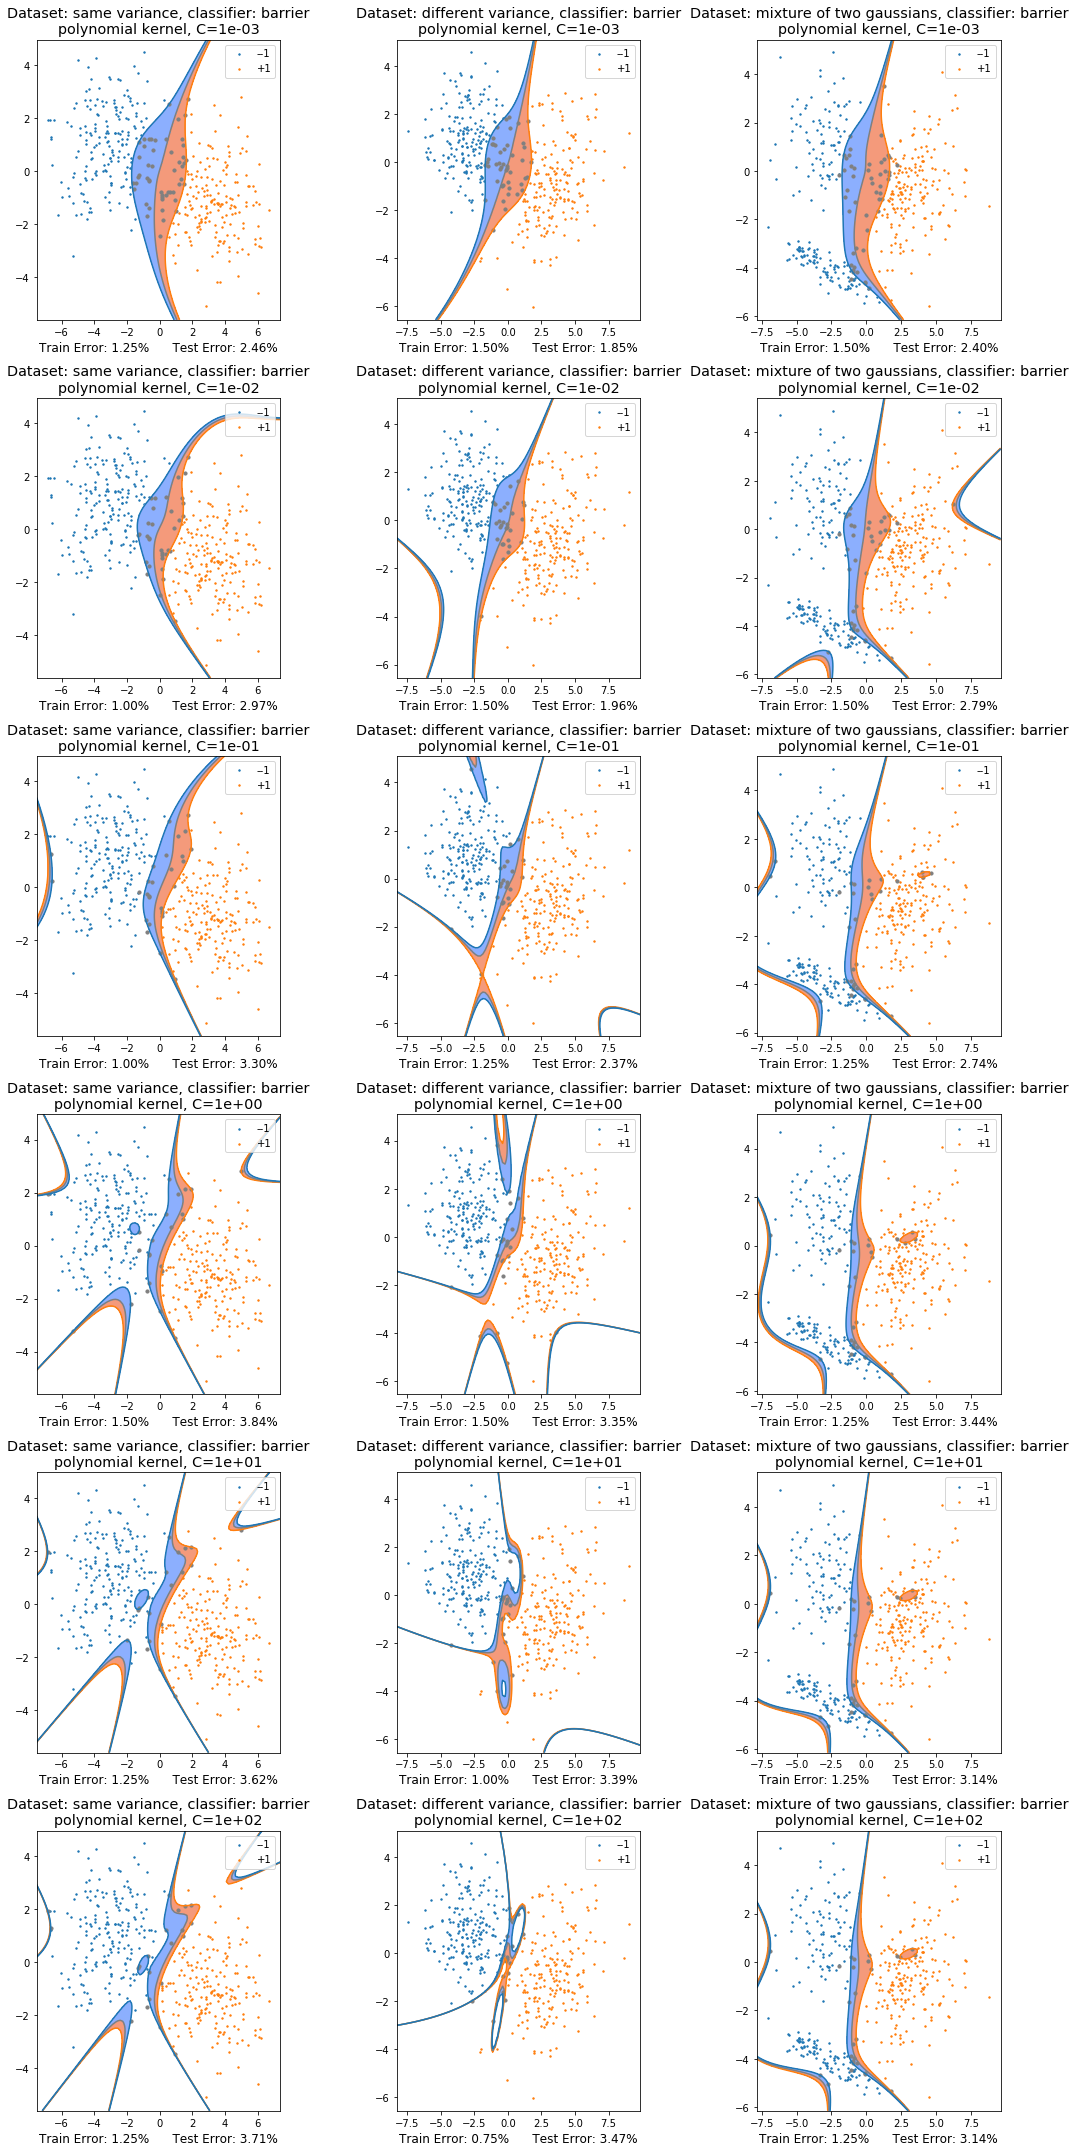

In [8]:
cs = 10.0**arange(-3,3)
n_cs = len(cs)

figure(figsize=(5*n_datasets,5*n_cs))
i = 0
for c in cs:
    for dataset in datasets:
        i += 1
        axes = subplot(n_cs, n_datasets, i)
        print("Dataset: {}, C={}".format(dataset, c))
        %time plot_results(axes, dataset, "barrier", "polynomial", c, c*1e-10)
tight_layout()

# TODO Commentary

### Duality Gap

### Comparison with other solvers

Dataset: same variance, barrier classifier
CPU times: user 2.3 s, sys: 40 ms, total: 2.34 s
Wall time: 718 ms
Dataset: different variance, barrier classifier
CPU times: user 3.81 s, sys: 172 ms, total: 3.98 s
Wall time: 1.36 s
Dataset: mixture of two gaussians, barrier classifier
CPU times: user 2.87 s, sys: 76 ms, total: 2.95 s
Wall time: 909 ms
Dataset: same variance, sklearn classifier
(400,) 400
CPU times: user 116 ms, sys: 8 ms, total: 124 ms
Wall time: 41.8 ms
Dataset: different variance, sklearn classifier
(400,) 400
CPU times: user 136 ms, sys: 20 ms, total: 156 ms
Wall time: 50.4 ms
Dataset: mixture of two gaussians, sklearn classifier
(400,) 400
CPU times: user 104 ms, sys: 4 ms, total: 108 ms
Wall time: 28.1 ms
Dataset: same variance, cvxopt classifier
CPU times: user 556 ms, sys: 8 ms, total: 564 ms
Wall time: 145 ms
Dataset: different variance, cvxopt classifier
CPU times: user 264 ms, sys: 4 ms, total: 268 ms
Wall time: 67.3 ms
Dataset: mixture of two gaussians, cvxopt cl

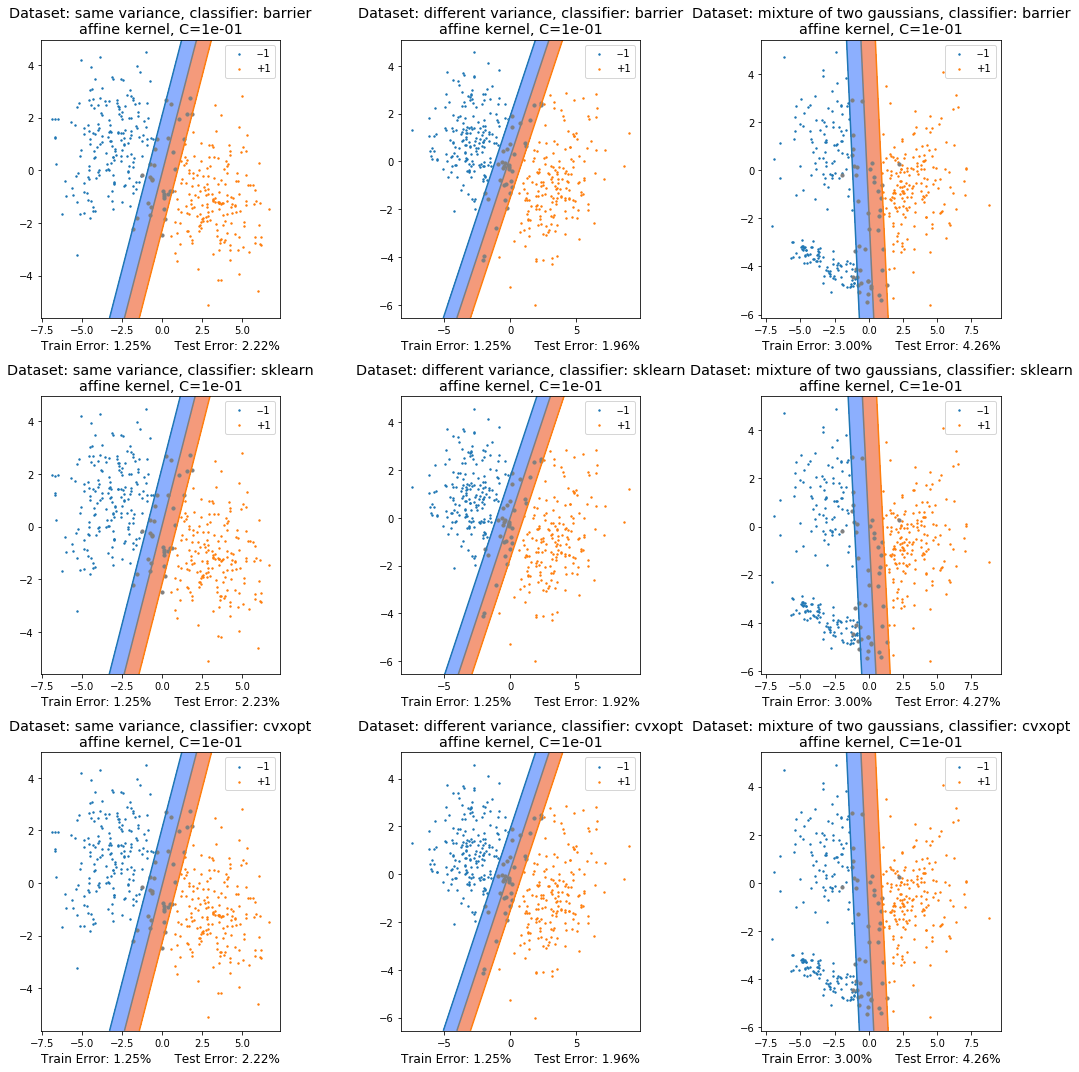

In [9]:
figure(figsize=(5*n_datasets,5*n_classifiers))
i = 0
for classifier in classifiers:
    for dataset in datasets:
        i += 1
        axes = subplot(n_classifiers, n_datasets, i)
        print("Dataset: {}, {} classifier".format(dataset, classifier))
        %time plot_results(axes, dataset, classifier, "affine", c=1e-1)
tight_layout()

# TODO Commentary

# TODO
Use the coordinate descent method to solve the dual. Plot duality gap versus iteration number and compare performance with the barrier method for various problem sizes (vary the number of samples and record to total CPU time required by each code to reduce the gap by a factor ${10}^{-3}$).

We want to solve for each $1 \le i \le n$ the following optimization problem:
\begin{equation*}
\begin{aligned}
& \underset{\alpha_i}{\text{minimize}}
& & \frac12 \alpha^T H\alpha - \mathbf{1}^T\alpha \\
& \text{subject to}
& & 0 \le \alpha_i \le C
\end{aligned}
\end{equation*}
where $H = \mathbf{diag}(y)XX^T\textbf{diag}(y)$.

We compute the derivative:
$$f'(α_i) = H_i^Tα-1$$
so the minimum is obtained in $$α_i = \frac{1 - α^TH'_i}{H_{i, i}} $$
where $H'_{i}$ is $H_i$ with a null $i^ {th}$ coordinate.

In [10]:
def coordinate_descent_method(h, α0, c, ε):
    m = len(α0)
    h_null = np.copy(h)
    diagonal = np.zeros(m)
    non_null_indices = np.nonzero(np.diag(h))[0]
    for i in non_null_indices:
        diagonal[i] = 1 / h[i, i]
        h_null[i, i] = 0
    
    def obj(α):
        return 0.5 * α.dot(np.dot(h, α)) - np.sum(α)
    
    α = α0
    new_obj = obj(α)
    while True:
        prev_obj = new_obj
        for i in non_null_indices:
            α[i] = max(min(diagonal[i] * (1 - np.dot(α, h_null[i])), c), 0)
        
        new_obj = obj(α)
        # TODO: Check syntax.
        if abs(new_obj - prev_obj) < ε:
            break
    
    return α


def svm_coordinate_descent(x, y, c, kernel, ε=1e-6, **descent_params):
    """
    Solve the SVM classifier problem.
    @param x is an array of shape (m,n): the m points in dimension n
    @param y is an array of shape m and of values in {-1,1}: the labels
    @param c is the margin parameter
    @param kernel is the kernel function, which takes 2D arrays as inputs
    @param ɛ is the required absolute precision
    @param descent_params are the additional coordinate descent method parameters
    @return a dictionnary, with at least the α field
    """
    m, n = x.shape
    # α = c/2 is a stricly feasible point.
    α0 = c/2 * ones(m)
    h = kernel(x, x) * y[:, None] * y[None, :]
    
    # This is a first order method, so it needs a kind epsilon.
    α = coordinate_descent_method(h, α0, c, max(ε, 1e-6))
    
    results = dict()
    results["α"] = α
    return results

classifiers["coordinate"] = svm_coordinate_descent
n_classifiers = len(classifiers)

CPU times: user 916 ms, sys: 28 ms, total: 944 ms
Wall time: 258 ms


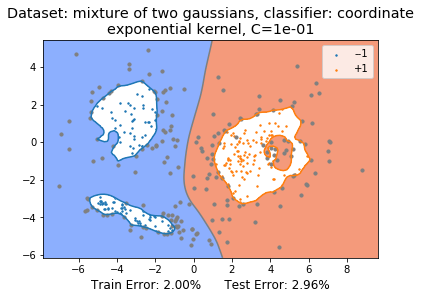

CPU times: user 3.6 s, sys: 128 ms, total: 3.72 s
Wall time: 1.09 s


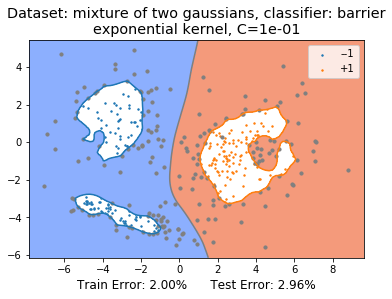

In [11]:
%time plot_results(axes, dataset, "coordinate", "exponential", c=1e-1)
plt.show()
%time plot_results(axes, dataset, "barrier", "exponential", c=1e-1)

# TODO
Use the logarithmic barrier code you wrote in HW1 to solve a small random instance of the primal problem using the ACCPM algorithm. Plot an upper bound on the distance to optimality in semilog scale and try various constraint dropping strategies. Compare convergence with the two other methods.